In [25]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles , make_moons

In [26]:
n_samples = 1000
X , y = make_circles(n_samples, noise=0.03,  random_state=43)

In [27]:
X.shape , y.shape

((1000, 2), (1000,))

In [28]:
import pandas as pd

df = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"Y":y})
df.head(5)

,X1,X2,Y
0,-0.124570,-0.785914,1
1,0.772370,-0.158252,1
2,-0.657123,0.768114,0
3,0.794009,0.051699,1
4,-0.642243,0.361384,1


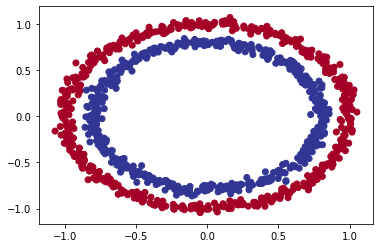

In [29]:
plt.scatter(X[:, 0], X[:, 1], c=y,  cmap=plt.cm.RdYlBu)

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32).unsqueeze(dim = 1)
split_percentage = int(0.8*len(X))
X_train , y_train = X[:split_percentage], y[:split_percentage]
X_test,y_test = X[split_percentage:], y[split_percentage:]

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print(y_train.shape)

torch.Size([800, 1])


In [32]:
import wandb
wandb.login()

True

In [33]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="email_detection",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "layer_1_size":10 ,
    "lauyer_2_size":20,
    
 
    "epochs": 10,
    }
)
config = wandb.config


In [34]:
class circle_model_v0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,out_features=config.layer_1_size)
        self.linear_layer2 = nn.Linear(in_features=config.layer_1_size,out_features=config.lauyer_2_size)
        self.linear_layer3 = nn.Linear(in_features=config.lauyer_2_size,out_features=1)
        
    def  forward(self,x : torch.tensor) -> torch.Tensor:
        return self.linear_layer3(self.linear_layer2(self.linear_layer1(x)))
    
def plotting(x,y,predictions = None):
    plt.scatter(x,y,c = "r")
    if predictions is not None:
        plt.scatter(x,predictions,c = "b")



In [35]:
model = circle_model_v0()
model.to(device)

circle_model_v0(
  (linear_layer1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=20, bias=True)
  (linear_layer3): Linear(in_features=20, out_features=1, bias=True)
)

In [36]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998],
         [ 0.5451,  0.1045],
         [-0.3301,  0.1802]], requires_grad=True),
 Parameter containing:
 tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
          0.0667, -0.6984], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
           0.0346, -0.0997],
         [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
           0.1606, -0.1927],
         [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,
           0.2475, -0.2247],
         [ 0.0199, -0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874,
          -0.1886, -0.1886],
         [ 0.2844,  0.1054,  0.3043, -0.2610,

In [37]:
model.state_dict()

OrderedDict([('linear_layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('linear_layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('linear_layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2

In [38]:
loss = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params = model.parameters(),lr = config.learning_rate)

In [39]:
def accuracy_fn(y_pred, y_true):
   correct = torch.eq(y_true,y_pred).sum().item()
   acc = (correct/len(y_pred)) * 100
   return acc

In [40]:
torch.manual_seed(42)
epochs  = config.epochs
epoch_set = []
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    model.train()
    y_preds = model(X_train)
  
    y_preds1 = torch.round(torch.sigmoid(y_preds))
    loss1 = loss(y_preds,y_train)
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    model.eval()
    epoch_set.append(epoch)
    train_loss.append(loss1.item())
    train_acc = accuracy_fn(y_preds1,y_train)
    train_accuracy.append(train_acc)
    with torch.inference_mode():
        y_logits_test = model(X_test)
        y_preds2 = torch.round(torch.sigmoid(y_logits_test))
        loss2 = loss(y_logits_test,y_test)
        test_loss.append(loss2.item())
        test_acc = accuracy_fn(y_preds2,y_test)
        test_accuracy.append(test_acc)
    wandb.log({"acc": train_acc, "loss": loss1})
    print("Epoch: {}, Train Loss: {}, Train acc: {} , Test Loss: {} , Test acc: {}".format(epoch,loss1.item(),train_acc,loss2.item(),test_acc))
    
    
    
    

Epoch: 0, Train Loss: 0.6952815055847168, Train acc: 51.625 , Test Loss: 0.7033554315567017 , Test acc: 39.0
Epoch: 1, Train Loss: 0.6935976147651672, Train acc: 41.75 , Test Loss: 0.7057331800460815 , Test acc: 39.0
Epoch: 2, Train Loss: 0.6934860348701477, Train acc: 41.875 , Test Loss: 0.7033523321151733 , Test acc: 42.0
Epoch: 3, Train Loss: 0.6927741765975952, Train acc: 49.75 , Test Loss: 0.7003456354141235 , Test acc: 44.0
Epoch: 4, Train Loss: 0.692756712436676, Train acc: 51.5 , Test Loss: 0.698594331741333 , Test acc: 45.5
Epoch: 5, Train Loss: 0.6932724118232727, Train acc: 52.625 , Test Loss: 0.6980180144309998 , Test acc: 45.0
Epoch: 6, Train Loss: 0.6933591365814209, Train acc: 53.75 , Test Loss: 0.6982805728912354 , Test acc: 46.0
Epoch: 7, Train Loss: 0.6929717063903809, Train acc: 51.74999999999999 , Test Loss: 0.6992332339286804 , Test acc: 43.5
Epoch: 8, Train Loss: 0.6925897002220154, Train acc: 51.5 , Test Loss: 0.7005170583724976 , Test acc: 42.5
Epoch: 9, Train L

In [41]:
y_preds_test = torch.sigmoid(y_logits_test)
y_preds_test = torch.round(y_preds_test)
print(y_preds_test,y_logits_test)
accuracy_fn(y_preds_test, y_test)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      

40.5

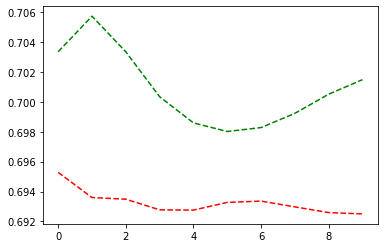

In [42]:
def plot_epoch_loss(epoch,loss,color):
    plt.plot(epoch,loss,color)
plot_epoch_loss(epoch_set,test_loss,color = "g--")
plot_epoch_loss(epoch_set,train_loss,color = "r--")

In [43]:
model.eval()
with torch.inference_mode():
    y_p = model(X_test)


In [44]:
torch.save(model.state_dict(),"models/circle_model_v0.pth")

In [45]:
# torch.cuda.manual_seed(42) for gpu

BCELOSS with logits come with sigmoid we dont want to put in after nn.linear_layr

but bceloss we want to use loss(torch.sigmoid(y_logits))

In [46]:
import requests
from pathlib import Path

if Path("helper.py").is_file():
    print("file existed")
else:
    print("Downloading from github repo  --  ")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper.py", "wb") as f:
        f.write(request.content)

file existed


torch.Size([1, 800, 2]) torch.Size([800])


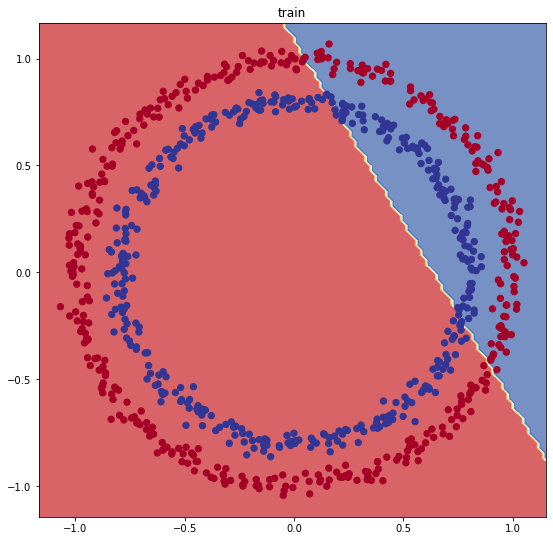

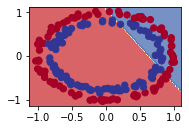

In [47]:
from helper import plot_decision_boundary,plot_predictions
print(X_train.unsqueeze(dim = 0).shape , y_train.squeeze(dim = 1).shape)
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("train")
plot_decision_boundary(model,X=X_train,y = y_train.squeeze(dim = 1))
plt.subplot(2,2,3)
plot_decision_boundary(model,X = X_test,y = y_test.squeeze(dim = 1))
 


Improve model's performance  --

1. Add more layers  - give chance to model to learn pattern
2. Add more hidden units  -  5 to 10 to 20
3. change activation function
4. change loss function
5. change optimizer function
6. Fit for longer i mean epochs
7. change learning rate


we use torch.utils.tensorboard

WE can use Sequential also 

In [48]:
# simulate training

    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

acc,▇▁▁▆▇▇█▇▇▆
loss,█▄▃▂▂▃▃▂▁▁
acc,50.0
loss,0.6925


In [49]:
!wandb launch-agent -e straw_hat -q new

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Starting launch agent ✨
wandb: WARNING launch: Agent is running on team entity (straw_hat). Members of this team will be able to run code on this device.
wandb: launch: agent pageaet8 polling on queues new, running 0 out of a maximum of 1 jobs
wandb: launch: agent pageaet8 polling on queues new, running 0 out of a maximum of 1 jobs
wandb: launch: agent pageaet8 polling on queues new, running 0 out of a maximum of 1 jobs
wandb: launch: agent pageaet8 polling on queues new, running 0 out of a maximum of 1 jobs
^C


In [50]:
!wandb agent straw_hat/email_detection/6rnqb7fp

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Starting wandb agent 🕵️
2023-08-02 00:10:42,531 - wandb.wandb_agent - INFO - Running runs: []
2023-08-02 00:10:43,157 - wandb.wandb_agent - INFO - Agent received command: run
2023-08-02 00:10:43,157 - wandb.wandb_agent - INFO - Agent starting run with config:
	architecture: Linear
	epochs: 16
	lauyer_2_size: 10
	layer_1_size: 13
	learning_rate: 0.007201338362256696
2023-08-02 00:10:43,160 - wandb.wandb_agent - INFO - About to run command: /usr/bin/env python train.py --architecture=Linear --epochs=16 --lauyer_2_size=10 --layer_1_size=13 --learning_rate=0.007201338362256696
/usr/bin/env: ‘python’: No such file or directory
2023-08-02 00:10:48,171 - wandb.wandb_agent - INFO - Running runs: ['99tw7slp']
2023-08-02 00:10:48,172 - wandb.wandb_agent - INFO - Cle